In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import keras
from keras import ops
from keras import utils
from keras.applications.imagenet_utils import decode_predictions
from keras import layers
import kimm
import tensorflow as tf
import tensorflow_datasets as tfds
import kimm

from PIL import Image  # For image loading and resizing
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 
pd.set_option('display.max_colwidth', None) # Display full width of columns pd.set_option('display.max_columns', None) # Display all columns pd.set_option('display.max_rows', None) # Display all rows pd.set_option('display.width', 200) # Set display width


In [2]:
import os
import pandas as pd
from keras.utils import to_categorical

# Define the base image directory and load the CSV file
base_image_dir = r"C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection"
retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])

# Define the image directory correctly
image_dir = os.path.join(base_image_dir, "train", "train")

# Correctly construct the paths to the images
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(image_dir, f'{x}.jpeg'))



# Check if images exist
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

# Add a column for left or right eye
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1] == 'left' else 0)

# Categorize the levels
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1 + retina_df['level'].max()))

# Drop rows with missing data and filter rows with existing images
retina_df.dropna(inplace=True)
retina_df = retina_df[retina_df['exists']]

# Display a sample of the data
print(retina_df.sample(3))



35126 images found of 35126 total
           image  level PatientId  \
583    704_right      0       704   
2142   2662_left      0      2662   
7569  9544_right      0      9544   

                                                                                                                    path  \
583    C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\704_right.jpeg   
2142   C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\2662_left.jpeg   
7569  C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\9544_right.jpeg   

      exists  eye                  level_cat  
583     True    0  [1.0, 0.0, 0.0, 0.0, 0.0]  
2142    True    1  [1.0, 0.0, 0.0, 0.0, 0.0]  
7569    True    0  [1.0, 0.0, 0.0, 0.0, 0.0]  


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

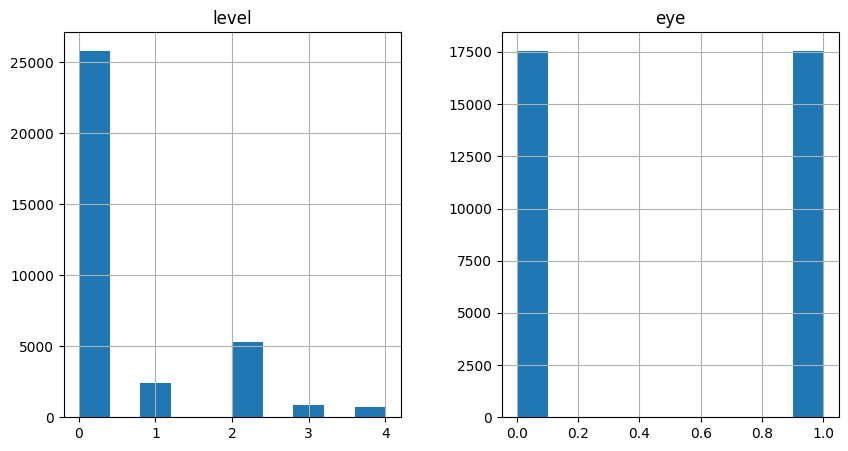

In [3]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

In [4]:
retina_df.head()

,image,level,PatientId,path,exists,eye,level_cat
0,10_left,0,10,C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\10_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,10_right,0,10,C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\10_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,13_left,0,13,C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\13_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,13_right,0,13,C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\13_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,15_left,1,15,C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\15_left.jpeg,True,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"


In [5]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 27176 validation 9632


New Data Size: 6000 Old Size: 27176


C:\Users\Illuminatus\AppData\Local\Temp\ipykernel_35076\2102671875.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(600, replace = True)


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

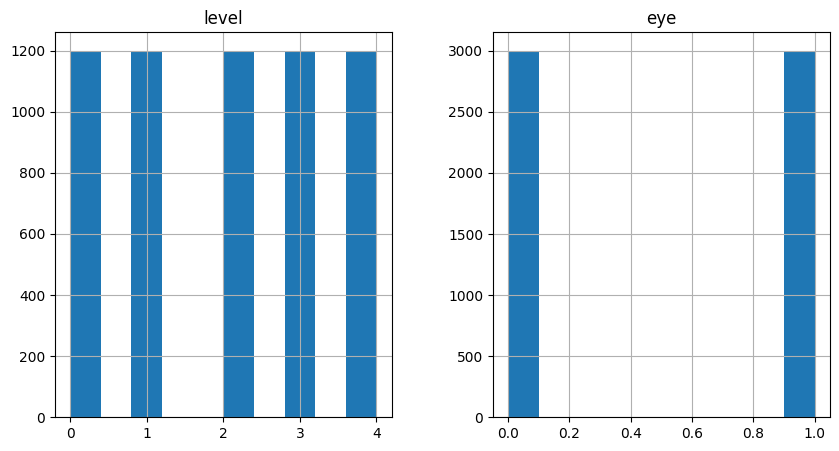

In [27]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(600, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))



<h1> splitting the datasets</h1>

Training set size: 2100
Validation set size: 450
Test set size: 450


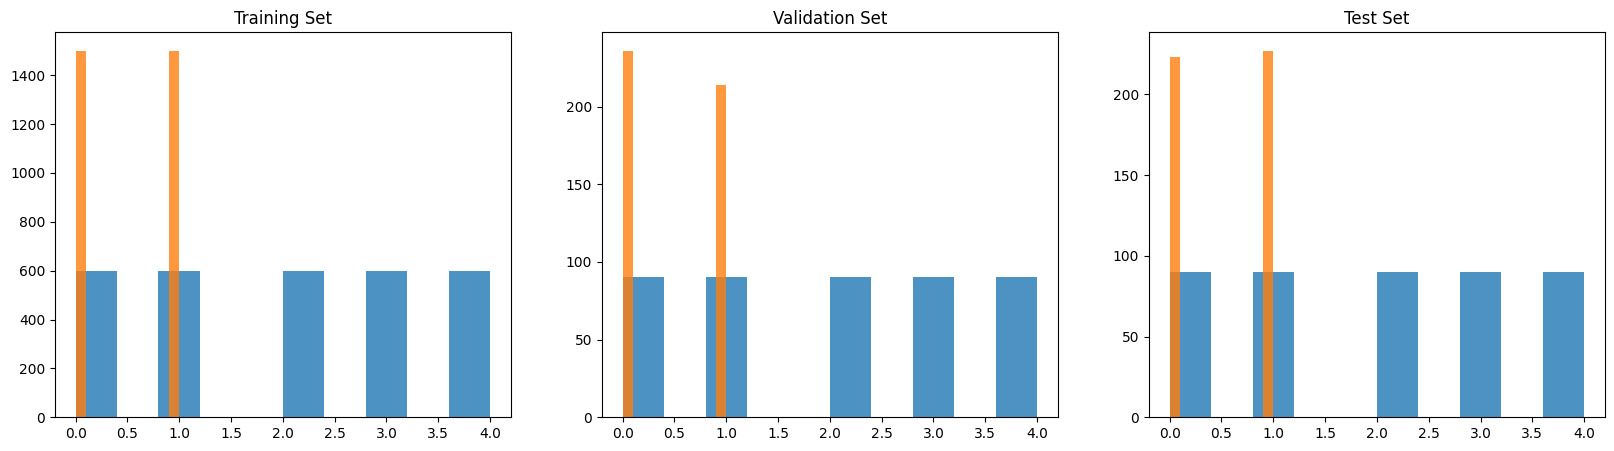

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
# Define the stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, temp_index in sss.split(train_df, train_df['level']):
    strat_train_df = train_df.iloc[train_index]
    strat_temp_df = train_df.iloc[temp_index]

# Further split the remaining 30% into validation and test sets
sss_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for valid_index, test_index in sss_valid.split(strat_temp_df, strat_temp_df['level']):
    valid_df = strat_temp_df.iloc[valid_index]
    test_df = strat_temp_df.iloc[test_index]

print('Training set size:', strat_train_df.shape[0])
print('Validation set size:', valid_df.shape[0])
print('Test set size:', test_df.shape[0])

# Histograms for each dataset
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot histograms for each dataset without clearing the figures
axes[0].hist(train_df['level'], bins=10, alpha=0.8, label='Training Set')
axes[0].hist(train_df['eye'], bins=10, alpha=0.8, label='Training Set')
axes[0].set_title('Training Set')

axes[1].hist(valid_df['level'], bins=10, alpha=0.8, label='Validation Set')
axes[1].hist(valid_df['eye'], bins=10, alpha=0.8, label='Validation Set')
axes[1].set_title('Validation Set')

axes[2].hist(test_df['level'], bins=10, alpha=0.8, label='Test Set')
axes[2].hist(test_df['eye'], bins=10, alpha=0.8, label='Test Set')
axes[2].set_title('Test Set')

plt.show()

<a> orange represents eye (left or right) blue represents severity (0,1,2,3,4) </br>
stratified sampling ensures different sub-groups are adequately represented in the sample </a>


In [8]:
# Define a function to load and resize images
def load_images(image_paths, target_size=(224, 224)):  # You can set the target_size depending on your needs
    images = []
    for path in image_paths:
        try:
            # Open the image file
            with Image.open(path) as img:
                # Resize the image to the target size
                img = img.resize(target_size)
                # Convert the image to a NumPy array
                img_array = np.array(img)
                # Append the image array to the list
                images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    
    # Convert the list of images to a NumPy array
    return np.array(images)

# Get the list of image paths
train_paths = train_df['path'].tolist()
test_paths = test_df['path'].tolist()
valid_paths = valid_df['path'].tolist()
print("finish process path")
# Load the images

train_img = load_images(train_paths)
print("finish load img")
test_img = load_images(test_paths)
print("finish load img")
valid_img = load_images(valid_paths)
print("finish load img")
# Print the shape of the resulting array
print(f"Loaded {len(train_img)} train images.")
print(f"Image data shape: {train_img.shape}")
print(f"Loaded {len(test_img)} test images.")
print(f"Image data shape: {test_img.shape}")
print(f"Loaded {len(valid_img)} valid images.")
print(f"Image data shape: {valid_img.shape}")

finish process path
finish load img
finish load img
finish load img
Loaded 3000 train images.
Image data shape: (3000, 224, 224, 3)
Loaded 450 test images.
Image data shape: (450, 224, 224, 3)
Loaded 450 valid images.
Image data shape: (450, 224, 224, 3)


In [12]:
print(train_df)

            image  level PatientId  \
0     33791_right      0     33791   
1     21764_right      0     21764   
2      8314_right      0      8314   
3     25058_right      0     25058   
4     32876_right      0     32876   
...           ...    ...       ...   
2995   24910_left      4     24910   
2996    4793_left      4      4793   
2997   15459_left      4     15459   
2998   20144_left      4     20144   
2999   31043_left      4     31043   

                                                                                                                     path  \
0     C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\33791_right.jpeg   
1     C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\21764_right.jpeg   
2      C:\Users\Illuminatus\projects\diabetic_retinopathy\data\diabetic-retinopathy-detection\train\train\8314_right.jpeg   
3     C:\Users\Illuminatus\projects\diabeti

<h1> Training model</h1>

<a> 'GhostNetV2W100', 'GhostNetV2W130', 'GhostNetV2W160', 'GhostNetV3W050', 'GhostNetV3W100', 'GhostNetV3W130', 'GhostNetV3W160', 'GhostNetW050', 'GhostNetW100', 'GhostNetW130' </a>

In [19]:
# Setup dataset with tf.data
resize_fn = keras.layers.Resizing(224, 224)

train_img_ds = tf.data.Dataset.from_tensor_slices(train_img)
# Extract labels from train_df and convert to a TensorFlow dataset
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_df['level'].values)
# Combine image and label datasets
train_ds = tf.data.Dataset.zip((train_img_ds, train_labels_ds))
#resize dataset
train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))


valid_img_ds = tf.data.Dataset.from_tensor_slices(valid_img)
valid_labels_ds = tf.data.Dataset.from_tensor_slices(valid_df['level'].values)
valid_ds = tf.data.Dataset.zip((valid_img_ds, valid_labels_ds))
valid_ds = valid_ds.map(lambda x, y: (resize_fn(x), y))

test_img_ds = tf.data.Dataset.from_tensor_slices(test_img)
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_df['level'].values)
test_ds = tf.data.Dataset.zip((test_img_ds, test_labels_ds))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))


# augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]


# def data_augmentation(x):
#     for layer in augmentation_layers:
#         x = layer(x)
#     return x


# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

batch_size = 64
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
validation_ds = valid_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

In [26]:
for images, labels in train_ds.take(2):
    print("Shape of input images:", images.shape)
    print("Shape of labels:", labels.shape)


Shape of input images: (64, 224, 224, 3)
Shape of labels: (64,)
Shape of input images: (64, 224, 224, 3)
Shape of labels: (64,)


In [24]:
base_model = kimm.models.GhostNetV3W100(
    input_shape=(224,224,3),
    include_preprocessing=True,
    include_top=False,
)

base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_721"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_725 (InputLayer)          │ (None, 224, 224, 3)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ GhostNetV3W100 (GhostNetV3W100)       │ (None, 7, 7, 960)             │      5,736,252 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ global_average_pooling2d_1            │ (None, 960)                   │              0 │    -    │
│ (GlobalAveragePooling2D)              │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dropout_1 (Dropout)                   │ (None, 960)                   │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_1 (Dense)                       │ (None, 1)                     │            961 │    Y    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 5,737,213 (21.89 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 5,736,252 (21.88 MB)

In [25]:
# You should achieve good results in 2 epochs
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

result = model.evaluate(test_ds)
print(f"Test accuracy: {result[1] * 100:3.2f}%")

Fitting the top layer of the model
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - binary_accuracy: 0.4777 - loss: -0.1280 - val_binary_accuracy: 0.2000 - val_loss: -9.0054
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - binary_accuracy: 0.2457 - loss: 0.1222 - val_binary_accuracy: 0.2000 - val_loss: -17.4384
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 818ms/step - binary_accuracy: 0.1956 - loss: -17.0025
Test accuracy: 20.00%


In [47]:
def flow_without_augmentation(in_df, path_col, y_col, shuffle=True, color_mode='rgb'):
    # Convert the DataFrame to a TensorFlow dataset
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values, 0)))
    
    in_len = in_df[path_col].values.shape[0]

    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len)  # Shuffle the whole dataset

        # Function to preprocess and load images without augmentation
        def load_image(path, label):
            image = tf.io.read_file(path)
            image = tf.image.decode_png(image, channels=3 if color_mode == 'rgb' else 1)
            image = tf.image.resize(image, (1024, 1024))
            # Apply preprocessing function
            image = preprocess_input(image)  # Inherit from Inception_V3
            return image, label

        files_ds = files_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        files_ds = files_ds.batch(48)
        files_ds = files_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        for batch in iter(files_ds):
            images, labels = batch
            yield images.numpy(), labels.numpy()

# Use the flow_without_augmentation function
train_gen = flow_without_augmentation(train_df, path_col='path', y_col='level_cat')
valid_gen = flow_without_augmentation(valid_df, path_col='path', y_col='level_cat')



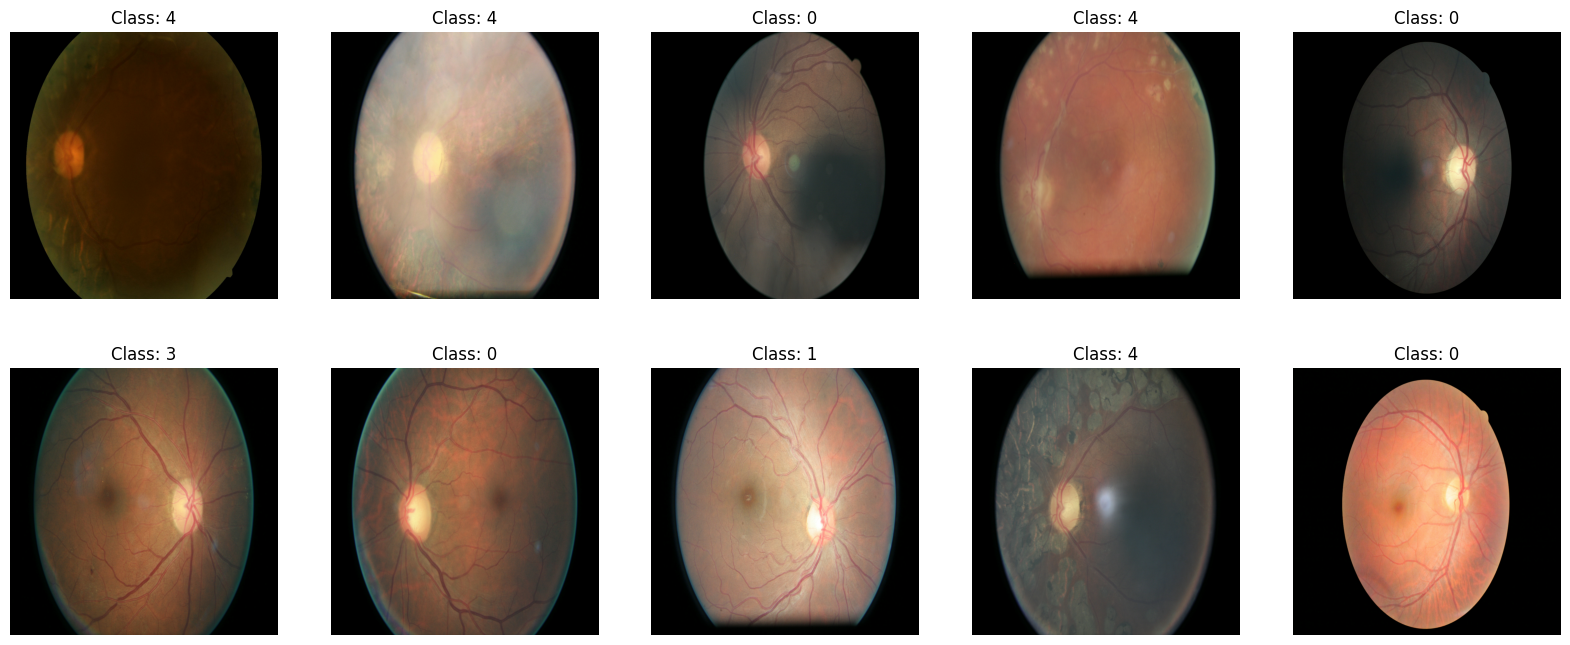

In [48]:

# Undo preprocessing: Rescale images to [0, 255] range for display
def undo_preprocess(images):
    images = (images + 1) * 127.5  # Assuming images were scaled to [-1, 1]
    images = np.clip(images, 0, 255)  # Clip values to ensure they fall within [0, 255]
    return images.astype(np.uint8)

# Fetch a batch of images and labels from the generator
images, labels = next(train_gen)

# Undo the preprocessing for display
images = undo_preprocess(images)

# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) 
for i, ax in enumerate(axes.flatten()):
    if i < len(images): 
        ax.imshow(images[i])
        ax.set_title('Class: {}'.format(np.argmax(labels[i])))
    ax.axis('off')
plt.show()


In [32]:
train_df['path']

0       C:\Users\Illuminatus\projects\diabetic retinopathy\data\diabetic-retinopathy-detection\train\train\13375_right.jpeg
1        C:\Users\Illuminatus\projects\diabetic retinopathy\data\diabetic-retinopathy-detection\train\train\4314_right.jpeg
2       C:\Users\Illuminatus\projects\diabetic retinopathy\data\diabetic-retinopathy-detection\train\train\32588_right.jpeg
3        C:\Users\Illuminatus\projects\diabetic retinopathy\data\diabetic-retinopathy-detection\train\train\6715_right.jpeg
4       C:\Users\Illuminatus\projects\diabetic retinopathy\data\diabetic-retinopathy-detection\train\train\37082_right.jpeg
                                                               ...                                                         
2995     C:\Users\Illuminatus\projects\diabetic retinopathy\data\diabetic-retinopathy-detection\train\train\38662_left.jpeg
2996      C:\Users\Illuminatus\projects\diabetic retinopathy\data\diabetic-retinopathy-detection\train\train\4909_left.jpeg
2997    

In [33]:
train_gen = dataframe_flow(train_df, path_col=train_df['path'], y_col='level_cat')
valid_gen = dataframe_flow(valid_df, path_col=valid_df['path'], y_col='level_cat')


In [34]:
import matplotlib.pyplot as plt

# Fetch a batch of images and labels from the generator
images, labels = next(train_gen)

# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns for 10 images
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].astype(np.uint8))  # Convert image to uint8 format
    ax.set_title('Class: {}'.format(np.argmax(labels[i])))
    ax.axis('off')  # Hide the axis

plt.show()


KeyError: "None of [Index(['C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\13375_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\4314_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\32588_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\6715_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\37082_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\15247_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\31441_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\39739_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\25331_right.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\43662_right.jpeg',\n       ...\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\27251_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\25985_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\2496_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\22906_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\23326_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\38662_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\4909_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\23326_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\40078_left.jpeg',\n       'C:\\Users\\Illuminatus\\projects\\diabetic retinopathy\\data\\diabetic-retinopathy-detection\\train\\train\\24853_left.jpeg'],\n      dtype='object', length=3000)] are in the [columns]"